In [ ]:
#import packages
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
#remove warnings after verifying code
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv(r'log2.csv',low_memory = False)

In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [ ]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [ ]:
data = data.rename(columns={"Source Port": "source_port", "Destination Port": "destination_port", "NAT Source Port": "nat_source_port", "NAT Destination Port": "nat_destination_port", "Bytes Sent": "bytes_sent", "Bytes Received": "bytes_received", "Elapsed Time (sec)": "elapsed_time"})

In [ ]:
#basically addresses can't be int64
data["source_port"] = data["source_port"].astype(str)
data["destination_port"] = data["destination_port"].astype(str)
data["nat_source_port"] = data["nat_source_port"].astype(str)
data["nat_destination_port"] = data["nat_destination_port"].astype(str)

In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_port           65532 non-null  object
 1   destination_port      65532 non-null  object
 2   nat_source_port       65532 non-null  object
 3   nat_destination_port  65532 non-null  object
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   bytes_sent            65532 non-null  int64 
 7   bytes_received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   elapsed_time          65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 6.0+ MB


In [ ]:
data.describe()

,Bytes,bytes_sent,bytes_received,Packets,elapsed_time,pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [ ]:
#check for null values
data.isnull().sum()

source_port             0
destination_port        0
nat_source_port         0
nat_destination_port    0
Action                  0
Bytes                   0
bytes_sent              0
bytes_received          0
Packets                 0
elapsed_time            0
pkts_sent               0
pkts_received           0
dtype: int64

In [ ]:
#view unique data in column 'class'
data['Action'].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64


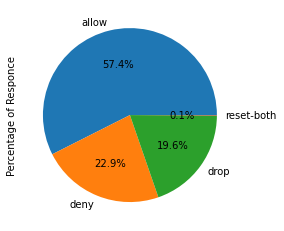

In [ ]:
#Visualize the data
print(data["Action"].value_counts())

data.groupby('Action').size().plot(kind='pie',
                                       y = "Action",
                                       label = "Percentage of Responce",
                                       autopct='%1.1f%%');

In [ ]:
data = data[data.Action != 'reset-both']

allow    37640
deny     14987
drop     12851
Name: Action, dtype: int64


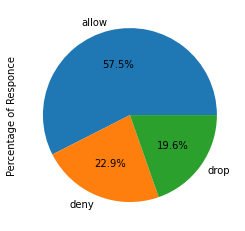

In [ ]:
#Visualize the data
print(data["Action"].value_counts())

data.groupby('Action').size().plot(kind='pie',
                                       y = "Action",
                                       label = "Percentage of Responce",
                                       autopct='%1.1f%%');

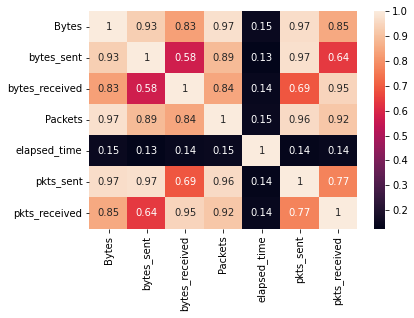

In [ ]:
#Delete Packets, Bytes, Bytes_recieved
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
data = data.drop(data.columns[[5, 8, 10, 11]], axis=1)

In [ ]:
x = data.loc[:,data.columns !='Action'] # Features
y = data['Action']  # Labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=444)

In [ ]:
#target_names = ['allow', 'deny', 'drop', 'reset-both']
target_names = ['allow', 'deny', 'drop']

In [ ]:
svcm0 = make_pipeline(StandardScaler(), SVC())
svcm0.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [ ]:
Pred0 = svcm0.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred0, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     11192
        deny       0.99      0.97      0.98      4508
        drop       0.96      1.00      0.98      3944

    accuracy                           0.99     19644
   macro avg       0.98      0.99      0.99     19644
weighted avg       0.99      0.99      0.99     19644



In [ ]:
svcm1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svcm1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
Pred1 = svcm1.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred1, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     11192
        deny       0.99      0.97      0.98      4508
        drop       0.96      1.00      0.98      3944

    accuracy                           0.99     19644
   macro avg       0.98      0.99      0.99     19644
weighted avg       0.99      0.99      0.99     19644



In [ ]:
#sig kernel/auto gammma - across board metris down
#sig kernel/scale gammma - sligthly better
#poly kernel/auto gammma/degree = 3 - better!
#poly kernel/auto gammma/degree = 4 - not as good!
#poly kernel/auto gammma/degree = 5 - HORRID
svcm2 = make_pipeline(StandardScaler(), SVC(kernel = 'poly', degree = 3, gamma='scale'))
svcm2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly'))])

In [ ]:
Pred2 = svcm2.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred2, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      0.97      0.99     11192
        deny       0.99      0.96      0.97      4508
        drop       0.90      1.00      0.95      3944

    accuracy                           0.98     19644
   macro avg       0.96      0.98      0.97     19644
weighted avg       0.98      0.98      0.98     19644



In [ ]:
sgdm0 = make_pipeline(StandardScaler(),
                     SGDClassifier())
sgdm0.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
Pred0_5 = sgdm0.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred0_5, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      0.99      1.00     11192
        deny       0.99      0.96      0.97      4508
        drop       0.95      1.00      0.97      3944

    accuracy                           0.99     19644
   macro avg       0.98      0.98      0.98     19644
weighted avg       0.99      0.99      0.99     19644



In [ ]:
sgdm1 = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=1000, tol=1e-3))
sgdm1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
Pred3 = sgdm1.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred3, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      0.99      1.00     11192
        deny       0.99      0.95      0.97      4508
        drop       0.94      1.00      0.97      3944

    accuracy                           0.99     19644
   macro avg       0.98      0.98      0.98     19644
weighted avg       0.99      0.99      0.99     19644



In [ ]:
#loss ='log', max_iter=1000, tol=1e-3 - precision drop
#loss ='hinge', max_iter=1000, tol=1e-3, penalty =  'l1' - all scores went up
#loss ='hinge', max_iter=1000, tol=1e-3, penalty =  'elasticnet' - mid
sgdm2 = make_pipeline(StandardScaler(),
                     SGDClassifier(loss ='hinge', max_iter=1000, tol=1e-3, penalty =  'l1'))
sgdm2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(penalty='l1'))])

In [ ]:
Pred4 = sgdm2.predict(X_test)

In [ ]:
#metrics
print(classification_report(y_test, Pred4, target_names=target_names))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     11192
        deny       0.99      0.97      0.98      4508
        drop       0.97      1.00      0.98      3944

    accuracy                           0.99     19644
   macro avg       0.99      0.99      0.99     19644
weighted avg       0.99      0.99      0.99     19644

